# Sumomo: Surrogate Modelling - Neural Networks

This notebook showcases the neural network surrogate modelling capabilities within `sumomo`.

### Imports

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

from sumomo import API
from utils import peaks, plot_peaks, plot_model, plot_activation

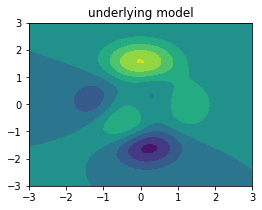

In [2]:
api = API(100, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')

api.y = peaks(api.x)
    
plot_peaks()

api.split()
api.scale()

## Nodes, layers, and networks

A neural network consists of sequential layers of nodes which map inputs variables onto output variables. A node receives inputs from nodes in the previous layer, performs a mathematical transformations, then emits the result to nodes in the subquent layer. Each network contains an input layer and an output layer, which emit the input variables and output variables respectively. Because of this, the input layer has a number of nodes equal to the number of inputs dimensions, whilst the output layer has a number of nodes equal to the number of outputs being modelled. In this way, only the input layer and output layer are evaluated by the user, mathematical transformations between these layers are carried out in hidden layers.

The structure of nodes and layers within neural networks define the type of network being used. One category of neural network structure are feedforward networks, in which layers are strctured sequentially and data flow through the network in a single pass from input layer to output layer. Another common structure is recurrent networks in which some data is returned to previous layers in the network. In this work, feedforward networks are considered. Specifically, fully dense feedforward networks are considered, in which all nodes in a given layer are connected to every node in the previous layer and every node in the next layer.

## Hidden layers

Within the hidden layers mathematical transformations map layer inputs onto layer outputs at each node. At each node, the following linear transformation takes place, where $\textbf{z}^{(k)}$ is the vector of outputs from layer $k$ with size equal to the number of nodes in that layer, $a_k()$ is an activation function applied to layer $k$, $W^{(k-1)}$ is the matrix of weights from the previous layer, and $\textbf{b}^{(k-1)}$ is the vector of biases from the previous layer with size equal to the number of nodes in the previous layer.

$$ \textbf{z}^{(k)} = a_k (W^{(k-1)} \textbf{z}^{(k-1)}+\textbf{b}^{(k-1)} ) $$

## Activation functions

Activation functions are applied to hidden layers, and sometimes output layers, to introduce non-linearaties into the network.

### Tanh

$$ \text{Tanh}(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}} = \frac{e^{2x}-1}{e^{2x}+1} = 1 - \frac{2}{e^{2x}+1} = \frac{1 -e^{-2x}}{1 + e^{-2x}} $$

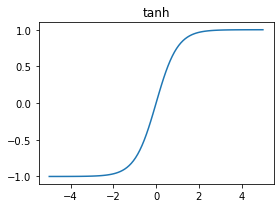

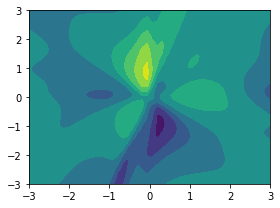

In [3]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='tanh')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('tanh')
plot_model(api)

### Sigmoid

$$ \text{Sigmoid}(x) = \frac{1}{1 + e^{-x} } $$

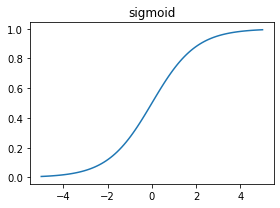

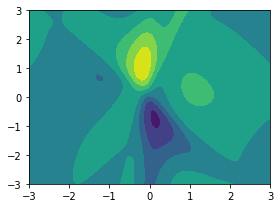

In [4]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='sigmoid')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('sigmoid')
plot_model(api)

### Softplus

$$ \text{Softplus}⁡(x)= \frac{1}{\beta} \log \left( 1 + \exp(\beta x) \right) $$

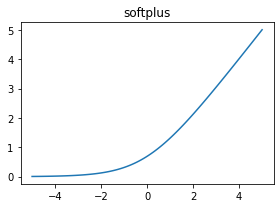

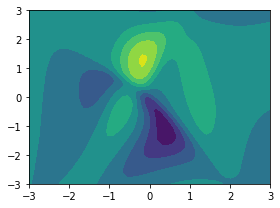

In [5]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='softplus')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('softplus')
plot_model(api)

### ReLU

$$ \text{ReLU}⁡(x) = \max (0, x) $$

$$ \begin{align}
z & \geq 0 \\
z & \geq x \\
z & \leq x + M(1-y) \\
z & \leq My \end{align} $$

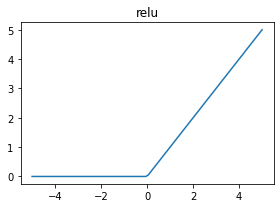

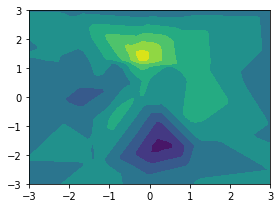

In [6]:
api.init_regressor('nn', hidden_layers=[10, 10], activation='relu')
api.regressor.fit(api.x_train_, api.y_train_)

plot_activation('relu')
plot_model(api)

In [7]:
mse = api.test('mse')
rmse = api.test('rmse')
print(mse)
print(rmse)

0.22777503828288095
0.4772578320812357


### Hardsigmoid

$$ \text{Hardsigmoid}(x) =  \begin{cases} 0 & \text{if } x\leq -3 \\ 1 & \text{if } x\geq +3 \\ x/6 + 1/2 & \text{otherwise} \end{cases} $$

$$ \begin{align}
z & \leq y_0 \\
z & \geq x / 6 + 0.5 - M(1 - y_0 + y_1) \\
z & \leq x / 6 + 0.5 + M(1 - y_0 + y_1) \\
z & \geq y_1 \\
z & \leq My_0 - 3 \\
z & \geq M(y_0 - 1) - 3 \\
z & \leq My_1 + 3 \\
z & \geq M(y_1 - 1) + 3 \end{align} $$

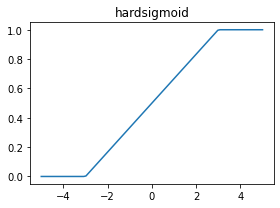

In [8]:
plot_activation('hardsigmoid')

## Building neural networks

Neural networks are built, trained, and used to make predictions using *PyTorch*.

In [9]:
def build_layers(layers, activation):
    torch_layers = []
    for i in range(len(layers) - 2):
        torch_layers.append( nn.Linear(layers[i], layers[i + 1]) )
        torch_layers.append( activation )
    torch_layers.append( nn.Linear(layers[-2], layers[-1]) )
    return torch_layers

def build_network(layers, activation):
    net = nn.Sequential(*build_layers(layers, activation))
    return net

net = build_network([2, 10, 10, 1], nn.Tanh())

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=1, bias=True)
)


## Training

In [10]:
api = API(100, [(-3.0, 3.0), (-3.0, 3.0)], 1, 'lhs')
api.y = peaks(api.x)

def fit(net, x, y):
    x_train, y_train = torch.Tensor(api.x), torch.Tensor(api.y)
    optimiser = torch.optim.Adam(net.parameters(), lr=1e-2)
    net.train()
    loss_func = nn.MSELoss()
    for epoch in range(1000):
        permutation = torch.randperm(len(x_train))
        for i in range(0, len(x_train), 10):
            idx = permutation[i:i+10]
            x_batch, y_batch = x_train[idx], y_train[idx] 
            predictions = net.forward(x_batch)
            loss = loss_func(predictions, y_batch)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

fit(net, api.x, api.y)

In [11]:
weights = []
biases = []
for layer in net:
    if isinstance(layer, nn.Linear):
        weights.append(layer.weight.data.numpy())
        biases.append(layer.bias.data.numpy())

## Predictions

In [12]:
def predict(net, x):
    x = torch.Tensor(x)
    net.eval()
    y = net.forward(x).detach().numpy()
    return y

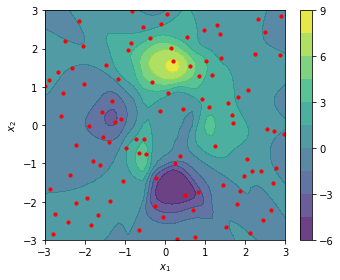

In [17]:
x1, x2 = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1grid, x2grid = np.meshgrid(x1, x2)
x_new = np.c_[x1grid.ravel(), x2grid.ravel()]

pred = predict(net, x_new)
pred = pred.reshape(x1grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
c = ax.contourf(x1, x2, pred, levels=12, alpha=0.8)
ax.scatter(api.x[:, 0], api.x[:, 1], s=10, c='r', cmap='bwr_r')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
fig.colorbar(c, ax=ax)

plt.tight_layout()

## Neural networks for classification

In [ ]:
# TODO

## NumPy formulations

In [ ]:
# TODO

## Simulataneous regression and classification

### 1-dimensional example

In [18]:
# TODO

### 2-dimensional example

In [19]:
# TODO